<a href="https://colab.research.google.com/github/dmurawski/magisterka/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Wczytanie bibliotek

In [ ]:
import torch
from torch import nn
import requests
import zipfile
from pathlib import Path
import os, sys, time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
from google.colab import files
import random
from torchvision import transforms
from torchsummary import summary

###Konfiguracja srodowiska

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"damianm23","key":"e615f2b87d831e39d186530b4d37aaa3"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


###Pobieranie i rozpakowywanie datasetu

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
try:
  import kaggle
except:
  !pip install kaggle
  import kaggle

image_path = Path("/content/data/Xray")

if not image_path.exists():
    image_path.mkdir(parents=True, exist_ok=True)
    print(f"Folder {image_path} został utworzony")
    api = KaggleApi()
    api.authenticate()
    dataset_name = 'nikhilpandey360/chest-xray-masks-and-labels'
    api.dataset_download_files(dataset_name, path=image_path)
    zip_file_name = "chest-xray-masks-and-labels.zip"
    destination_path = image_path / zip_file_name
    with zipfile.ZipFile(destination_path, "r") as zip_ref:
        print("Rozpakowywanie")
        zip_ref.extractall(image_path)
    os.remove(destination_path)
    print("Pobranie i rozpakowywanie zakończone")
else:
    print(f"Folder {image_path} już istnieje. Nie ma potrzeby pobierania danych.")

Folder /content/data/Xray został utworzony
Dataset URL: https://www.kaggle.com/datasets/nikhilpandey360/chest-xray-masks-and-labels
Rozpakowywanie
Pobranie i rozpakowywanie zakończone


###Wczytanie danych

In [164]:
img_dir = '/content/data/Xray/Lung Segmentation/CXR_png'
mask_dir = '/content/data/Xray/Lung Segmentation/masks'

In [165]:
mask_names = os.listdir (mask_dir)

In [166]:
random.seed(42)
def shuffle_split (mask_names, val_pct = 0.15):
    n_val = int (len (mask_names) * val_pct)
    idx = np.random.permutation (len (mask_names))
    mask_names = np.array (mask_names) [idx]
    return mask_names [n_val:], mask_names [:n_val]

In [167]:
class lungDataset (Dataset):
    def __init__ (self, image_dir, mask_dir, mask_names, transform = None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.mask_names = mask_names
        self.transform = transform
    def __getitem__ (self, index):
        mask_path = os.path.join (self.mask_dir, self.mask_names [index])
        image_path = os.path.join (self.image_dir, self.mask_names [index].replace ('_mask.png', '.png') if 'mask' in self.mask_names [index] else self.mask_names [index])
        image = np.array (Image.open (image_path).convert ('L'), dtype = np.float32)
        mask = np.array (Image.open (mask_path).convert ('L'), dtype = np.float32)
        mask [mask == 255] = 1
        if self.transform is not None:
            augmentations = self.transform (image = image, mask =  mask)
            image = augmentations ['image']
            mask = augmentations ['mask']
        return image, mask
    def __len__ (self):
        return len (self.mask_names)

###Augmentacja oraz zmiana rozmiaru

In [168]:
trn_tfms = A.Compose ([
    A.Resize (height = 128, width = 128),
    A.Normalize (0, 1, max_pixel_value = 255.0),
    ToTensorV2 ()
])

val_tfms = A.Compose ([
    A.Resize (height = 128, width = 128),
    A.Normalize (0, 1, max_pixel_value = 255.0),
    ToTensorV2 ()
])

###Podzielenie danych na część treningowa i testowa

In [169]:
random.seed(42)
mask_names = os.listdir(mask_dir)[:100]
trn_mask_names, val_mask_names = shuffle_split (mask_names)

train_ds = lungDataset (img_dir, mask_dir, trn_mask_names, trn_tfms)
valid_ds = lungDataset (img_dir, mask_dir, val_mask_names, val_tfms)

train_dl = DataLoader (train_ds, batch_size = 4, shuffle = True,  pin_memory = True)
valid_dl = DataLoader (train_ds, batch_size = 4, shuffle = False,  pin_memory = True)


###Wyświelenie kilku losowych rtg wraz z ich maskami

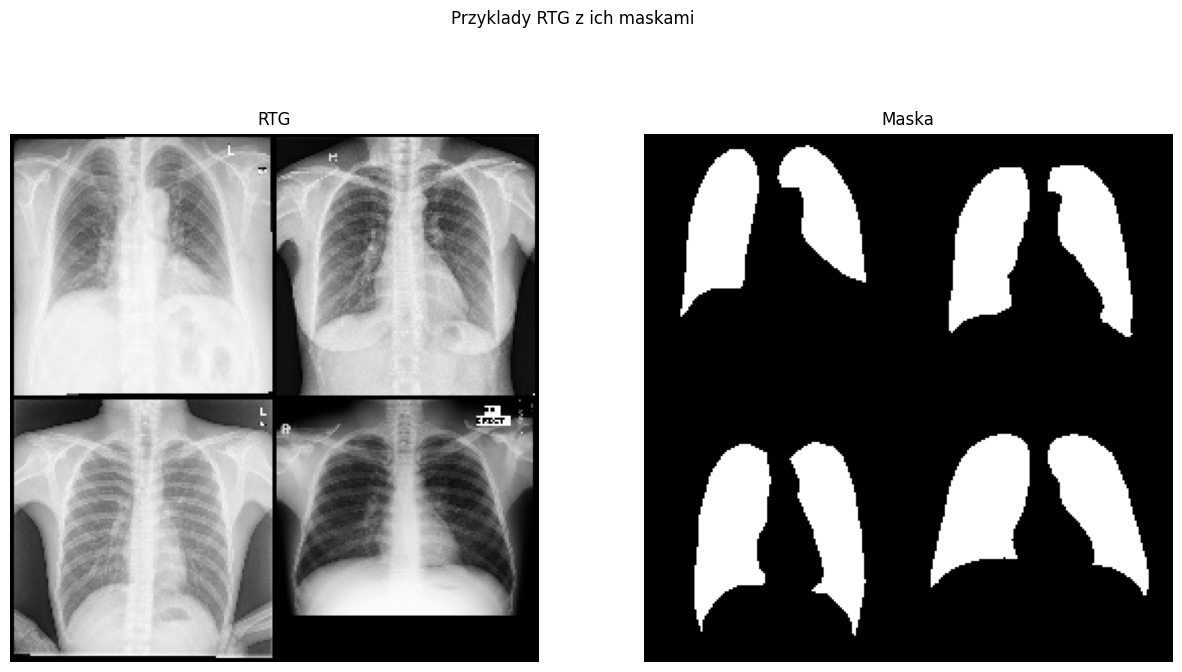

In [170]:
def imshow(img, mask, title=None):
    img = img.numpy().transpose(1, 2, 0)
    mean = 0
    std = 1
    img = img * std + mean
    img = np.clip(img, 0, 1)

    mask = mask.numpy().transpose(1, 2, 0)
    mask = np.clip(mask, 0, 1)

    fig, axes = plt.subplots(1, 2, figsize=(15, 8))

    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title("RTG")

    axes[1].imshow(mask.squeeze(), cmap='gray')
    axes[1].axis('off')
    axes[1].set_title("Maska")

    if title:
        fig.suptitle(title)

    plt.show()

img, msk = next(iter(train_dl))
img = torchvision.utils.make_grid(img, nrow=2)
msk = msk.unsqueeze(1)
msk = torchvision.utils.make_grid(msk, nrow=2)

imshow(img, msk, 'Przyklady RTG z ich maskami')

###Definicja sieci ResUnet

In [171]:
class InitBlock (nn.Module):
    def __init__ (self, in_channels = 3, out_channels = 3, stride = 1):
        super(InitBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d (in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d (out_channels),
            nn.ReLU (),
            nn.Conv2d (out_channels, out_channels, kernel_size = 3, padding = 1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d (in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d (out_channels),
        )
    def forward(self, x):
        return self.conv_block(x) + self.conv_skip(x)

In [172]:
class ResBlock (nn.Module):
    def __init__ (self, in_channels, out_channels, stride = 2):
        super(ResBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d (in_channels),
            nn.ReLU (),
            nn.Conv2d (in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d (out_channels),
            nn.ReLU (),
            nn.Conv2d (out_channels, out_channels, kernel_size = 3, padding = 1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d (in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d (out_channels),
        )
    def forward(self, x):
        return self.conv_block(x) + self.conv_skip(x)

In [173]:
class ResUnet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 1, features = [3, 6, 12]):
        super(ResUnet, self).__init__()

        #warstwa wejsciowa
        self.input = InitBlock (in_channels, features [0])
        self.downs = nn.ModuleList ()
        self.ups   = nn.ModuleList ()

        for feature in features:
            self.downs.append (ResBlock (feature, feature * 2, stride = 2))
            feature *= 2

        for feature in reversed (features):
            self.ups.append (nn.ConvTranspose2d (2 * feature, 2 * feature, kernel_size = 2, stride = 2))
            self.ups.append (ResBlock (2 * feature + feature, feature, stride = 1))

        self.output = nn.Conv2d(features [0], out_channels, kernel_size = 1)

    def forward (self, x):
        skip_connections = []
        x = self.input (x)
        skip_connections.append (x)

        for i, down in enumerate (self.downs):
            x = down (x)
            if i < 2:
                skip_connections.append (x)

        skip_connections = skip_connections [::-1]

        for idx in range (0, len (self.ups), 2):
            x = self.ups [idx] (x)
            skip_connection = skip_connections [idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize (x, skip_connection.shape [2:])

            concat_skip = torch.cat ((skip_connection, x), dim = 1)
            x = self.ups [idx + 1] (concat_skip)

        return self.output (x)

###Funkcja straty

In [174]:
class lungLoss (nn.Module):
    """ BCE , jaccard_loss and dice_loss """
    def __init__ (self, weight = None, size_average = True):
        super (lungLoss, self).__init__ ()

    def forward (self, outputs, targets, smooth = 1e-8):
        outputs = torch.sigmoid (outputs)
        outputs = outputs.view (-1)
        targets = targets.view (-1)

        intersection = (outputs * targets).sum ()
        union = (outputs.sum () + targets.sum ()) - intersection

        jaccard_loss = 1 - (intersection / (union + smooth))
        dice_loss = 1 - (2. * intersection) / (outputs.sum () + targets.sum () + smooth)
        BCE = F.binary_cross_entropy (outputs, targets, reduction = 'mean')

        loss = BCE + jaccard_loss + dice_loss

        return loss

###Metryki oceniajace skuteczność modelu

In [175]:
def calculate_metrics (outputs, targets, smooth = 1e-8):
    outputs = torch.sigmoid (outputs)
    preds = (outputs > 0.5).float ()
    intersection = (preds * targets).sum ()
    accuracy = (preds == targets).sum () / torch.numel (preds)
    dice = (intersection * 2.) / ((preds + targets).sum () + smooth)
    iou = (intersection) / ((preds + targets).sum () - intersection + smooth)

    return accuracy, dice, iou

###Funkcje zapisujace wartości modelu po przejściu iteracji oraz funckja wczytujaca wartości

In [176]:
def save_checkpoint (state, filename):
    print ('=> saving checkpoint')
    torch.save (state, filename)

def load_checkpoint (checkpoint, model):
    print ('=> loading checkpoint')
    model.load_state_dict (checkpoint ['state_dict'])

###Funkcja trenujaca model

In [177]:
def train(model, loader, loss_fn, optimizer, metric_fn, device):
    model.train()
    total_loss, total_accuracy, total_dice, total_iou = 0.0, 0.0, 0.0, 0.0
    num_batches = len(loader)

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.float().unsqueeze(1).to(device)
        outputs = model(inputs)

        loss = loss_fn(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc, dice, iou = metric_fn(outputs, targets)
        total_loss += loss.item()
        total_accuracy += acc
        total_dice += dice
        total_iou += iou

    return total_loss / num_batches, total_accuracy / num_batches, total_dice / num_batches, total_iou / num_batches

###Ta funkcja służy do oceny modelu na zestawie danych testowych

In [178]:
def evaluate(model, loader, loss_fn, metric_fn, device):
    model.eval()
    total_loss, total_accuracy, total_dice, total_iou = 0.0, 0.0, 0.0, 0.0
    num_batches = len(loader)

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            total_loss += loss_fn(outputs, targets).item()

            acc, dice, iou = metric_fn(outputs, targets)
            total_accuracy += acc
            total_dice += dice
            total_iou += iou

    return total_loss / num_batches, total_accuracy / num_batches, total_dice / num_batches, total_iou / num_batches


###Ta funkcja służy do trenowania modelu na zestawie danych treningowych i oceniania go na zestawie walidacyjnym w określonej liczbie epok

In [179]:
def fit(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs, metric_fn, device, checkpoint_path, scheduler=None, load_model=False):
    metrics = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': [], 'dice': [], 'val_dice': [], 'iou': [], 'val_iou': []}
    best_loss = 10000
    since = time.time()

    for epoch in range(num_epochs):
        train_loss, train_acc, train_dice, train_iou = train(model, train_dl, loss_fn, optimizer, metric_fn, device)
        val_loss, val_acc, val_dice, val_iou = evaluate(model, valid_dl, loss_fn, metric_fn, device)

        metrics['loss'].append(train_loss)
        metrics['acc'].append(train_acc)
        metrics['dice'].append(train_dice)
        metrics['iou'].append(train_iou)

        metrics['val_loss'].append(val_loss)
        metrics['val_acc'].append(val_acc)
        metrics['val_dice'].append(val_dice)
        metrics['val_iou'].append(val_iou)

        # Aktualizuje listę metryk treningowych i walidacyjnych dla bieżącej epoki
        if scheduler is not None:
            scheduler.step(val_acc)

        # Jeśli bieżąca wartość straty na zestawie walidacyjnym jest niższa niż najlepsza dotychczasowa wartość, zapisuje stan modelu i optymalizatora jako punkt kontrolny.
        if val_loss < best_loss:
            checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            save_checkpoint(checkpoint, checkpoint_path)
            best_loss = val_loss

        print('Epoch [{}/{}], loss: {:.4f} - acc: {:.4f} - dice: {:.4f} - iou: {:.4f} | val_loss: {:.4f} - val_acc: {:.4f} - val_dice: {:.4f} - val_iou: {:.4f}'
              .format(epoch + 1, num_epochs, train_loss, train_acc, train_dice, train_iou, val_loss, val_acc, val_dice, val_iou))

    training_time = time.time() - since
    print('Czas trenowania modelu: {:.0f}m {:.0f}s'.format(training_time // 60, training_time % 60))

    return metrics

In [180]:
model =  ResUnet (in_channels = 1, out_channels = 1).to(device)
loss_fn = lungLoss ().to(device)
optimizer = optim.Adam (model.parameters (), lr = 1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau (optimizer, factor = 0.1, patience = 3)
checkpoint_path = 'LungResUnet.pth'

In [181]:
history = fit (model, train_dl, valid_dl, loss_fn, optimizer, 5, calculate_metrics, device, checkpoint_path, scheduler)

=> saving checkpoint
Epoch [1/5], loss: 2.2851 - acc: 0.3113 - dice: 0.3878 - iou: 0.2415 | val_loss: 2.2436 - val_acc: 0.2582 - val_dice: 0.4086 - val_iou: 0.2580
=> saving checkpoint
Epoch [2/5], loss: 2.1906 - acc: 0.4470 - dice: 0.4569 - iou: 0.2969 | val_loss: 2.1583 - val_acc: 0.3919 - val_dice: 0.4519 - val_iou: 0.2931
=> saving checkpoint
Epoch [3/5], loss: 2.1071 - acc: 0.5157 - dice: 0.4959 - iou: 0.3304 | val_loss: 2.0398 - val_acc: 0.5268 - val_dice: 0.5100 - val_iou: 0.3436
=> saving checkpoint
Epoch [4/5], loss: 1.9974 - acc: 0.5404 - dice: 0.5122 - iou: 0.3454 | val_loss: 1.8905 - val_acc: 0.5838 - val_dice: 0.5433 - val_iou: 0.3744
=> saving checkpoint
Epoch [5/5], loss: 1.8852 - acc: 0.6087 - dice: 0.5558 - iou: 0.3861 | val_loss: 1.8226 - val_acc: 0.6409 - val_dice: 0.5805 - val_iou: 0.4104
Czas trenowania modelu: 2m 42s


###Warstwy modelu

In [182]:
summary(model, input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 128, 128]              30
       BatchNorm2d-2          [-1, 3, 128, 128]               6
              ReLU-3          [-1, 3, 128, 128]               0
            Conv2d-4          [-1, 3, 128, 128]              84
            Conv2d-5          [-1, 3, 128, 128]              30
       BatchNorm2d-6          [-1, 3, 128, 128]               6
         InitBlock-7          [-1, 3, 128, 128]               0
       BatchNorm2d-8          [-1, 3, 128, 128]               6
              ReLU-9          [-1, 3, 128, 128]               0
           Conv2d-10            [-1, 6, 64, 64]             168
      BatchNorm2d-11            [-1, 6, 64, 64]              12
             ReLU-12            [-1, 6, 64, 64]               0
           Conv2d-13            [-1, 6, 64, 64]             330
           Conv2d-14            [-1, 6,

In [183]:
torch.save (model, 'FullLungResUnet3_6_12.pth')

In [184]:
loss = history ['loss']
val_loss = history ['val_loss']
acc = history ['acc']
val_acc = history ['val_acc']
dice = history ['dice']
val_dice = history ['val_dice']
iou = history ['iou']
val_iou = history ['val_iou']

In [185]:
def plot_metrics (loss, val_loss, acc, val_acc, dice, val_dice, iou, val_iou):
    fig, ax = plt.subplots (1, 4, figsize = (20, 4))
    ax [0].plot (range (len (loss)), loss, 'b-', label = 'Training')
    ax [0].plot (range (len (loss)), val_loss, 'bo-', label = 'Test')
    ax [0].set_title ('Loss')
    ax [0].legend ()

    ax [1].plot (range (len (loss)), acc, 'b-', label = 'Training')
    ax [1].plot (range (len (loss)), val_acc, 'bo-', label = 'Test')
    ax [1].set_title ('Accuracy')
    ax [1].legend ()

    ax [2].plot (range (len (loss)), dice, 'b-', label = 'Training')
    ax [2].plot (range (len (loss)), val_dice, 'bo-', label = 'Test')
    ax [2].set_title ('Dice Score')
    ax [2].legend ()

    ax [3].plot (range (len (loss)), iou, 'b-', label = 'Training')
    ax [3].plot (range (len (loss)), val_iou, 'bo-', label = 'Test')
    ax [3].set_title ('IOU Score')
    ax [3].legend ()

    plt.show ()

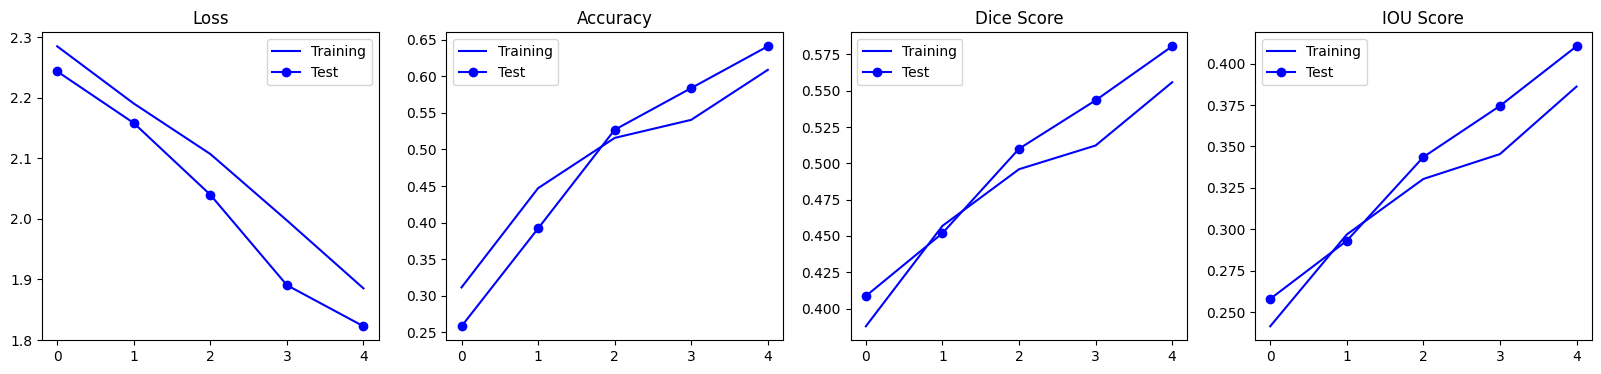

In [186]:
def convert_to_tensor(*args):
    return [torch.tensor(arg).cpu().numpy() for arg in args]

loss_tensor, val_loss_tensor, acc_tensor, val_acc_tensor, dice_tensor, val_dice_tensor, iou_tensor, val_iou_tensor = convert_to_tensor(loss, val_loss, acc, val_acc, dice, val_dice, iou, val_iou)

plot_metrics(loss_tensor, val_loss_tensor, acc_tensor, val_acc_tensor, dice_tensor, val_dice_tensor, iou_tensor, val_iou_tensor)

In [187]:
def tensor_to_array (img):
    return img.cpu ().numpy ().transpose (1, 2, 0)

In [188]:
def compare_masks(pred, mask):
    intersection = (pred * mask).sum().item()
    union = pred.sum().item() + mask.sum().item() - intersection
    return (intersection / union) * 100

def show_results(model, valid_dl, checkpoint_path=None):
    if checkpoint_path is not None:
        load_checkpoint(torch.load(checkpoint_path), model)

    images, masks = next(iter(valid_dl))
    images = images.to(device)
    masks = masks.unsqueeze(1).to(device)
    outputs = model(images)
    preds = (outputs > 0.5).float()

    plt.figure(figsize=(15, 20))
    for i in range(len(preds)):
        plt.subplot(4, 3, 3 * i + 1)
        plt.title('Orginalne RTG')
        image = images[i]
        plt.imshow(tensor_to_array(image), cmap='gray')

        plt.subplot(4, 3, 3 * i + 2)
        plt.title('Maska')
        mask = masks[i]
        plt.imshow(tensor_to_array(mask), cmap='gray')

        plt.subplot(4, 3, 3 * i + 3)
        pred = preds[i]
        plt.title('Przewidywana maska - {:.2f}%'.format(compare_masks(pred, mask)))
        plt.imshow(tensor_to_array(pred), cmap='gray')

    plt.show()

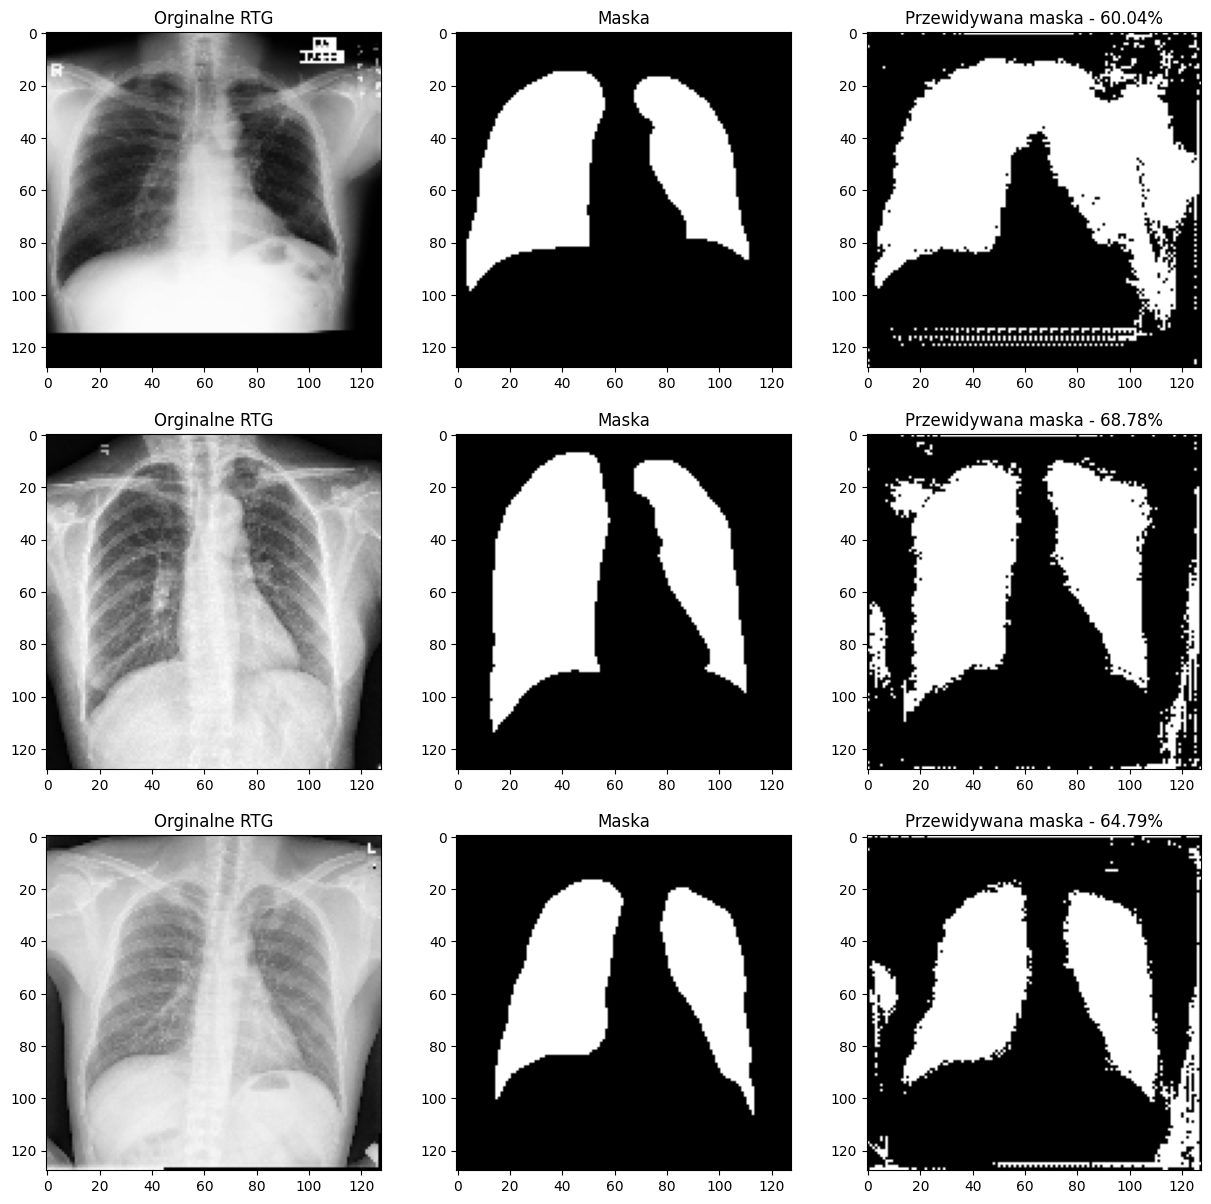

In [189]:
test_xray = DataLoader (train_ds, batch_size = 3, shuffle = True,  pin_memory = True)
show_results (model, test_xray)

In [190]:
def load_checkpoint(checkpoint_path, model):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    print("Wczytanie checkpoint:", checkpoint_path)

load_checkpoint('LungResUnet.pth', model)

Wczytanie checkpoint: LungResUnet.pth


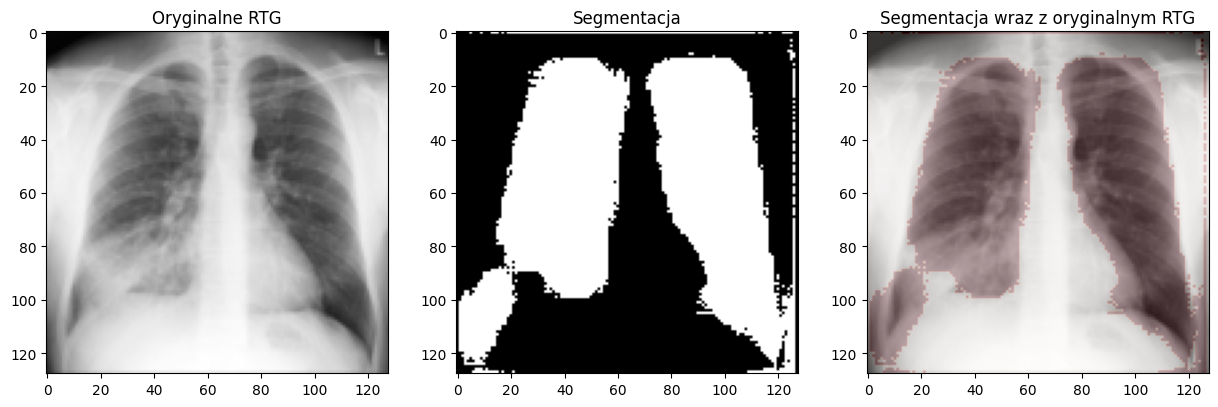

In [191]:
def predict_mask(model, image_path):
    image = Image.open(image_path).convert('L')  # Wczytanie obrazu w skali szarości

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])

    image_tensor = transform(image).unsqueeze(0)  # Dodanie wymiaru batcha

    # Przekazanie obrazu przez model
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        output = model(image_tensor)

    # Prognoza maski
    predicted_mask = (output > 0.5).float()

    # Wyświetlenie obrazu, przewidywanej maski i zaznaczonej segmentacji
    plt.figure(figsize=(15, 5))

    # Oryginalny obraz
    plt.subplot(1, 3, 1)
    plt.title("Oryginalne RTG")
    plt.imshow(image_tensor.squeeze().cpu().numpy(), cmap='gray')

    # Przewidywana maska
    plt.subplot(1, 3, 2)
    plt.title("Segmentacja")
    plt.imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')

    # Zaznaczona segmentacja na oryginalnym obrazie
    plt.subplot(1, 3, 3)
    plt.title("Segmentacja wraz z oryginalnym RTG")
    plt.imshow(image_tensor.squeeze().cpu().numpy(), cmap='gray')
    plt.imshow(predicted_mask.squeeze().cpu().numpy(), cmap='Reds', alpha=0.2)  # Zaznaczanie czerwoną linii

    plt.show()

# Przykładowe użycie
image_path = '/content/zapalenie-test.jpeg'
predict_mask(model, image_path)

###Ten sam model tylko 10 iteracji

In [192]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
# Hyper functions
model =  ResUnet (in_channels = 1, out_channels = 1).to(device)
loss_fn = lungLoss ().to(device)
optimizer = optim.Adam (model.parameters (), lr = 1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau (optimizer, factor = 0.1, patience = 3)

In [193]:
history = fit (model, train_dl, valid_dl, loss_fn, optimizer, 10, calculate_metrics, device, checkpoint_path, scheduler)

=> saving checkpoint
Epoch [1/10], loss: 2.1162 - acc: 0.6462 - dice: 0.3427 - iou: 0.2077 | val_loss: 2.1233 - val_acc: 0.7092 - val_dice: 0.0198 - val_iou: 0.0101
=> saving checkpoint
Epoch [2/10], loss: 2.0561 - acc: 0.6832 - dice: 0.4563 - iou: 0.2978 | val_loss: 2.0579 - val_acc: 0.7109 - val_dice: 0.4930 - val_iou: 0.3289
=> saving checkpoint
Epoch [3/10], loss: 1.9813 - acc: 0.7470 - dice: 0.5927 - iou: 0.4230 | val_loss: 1.9206 - val_acc: 0.7817 - val_dice: 0.6422 - val_iou: 0.4743
=> saving checkpoint
Epoch [4/10], loss: 1.8866 - acc: 0.7982 - dice: 0.6807 - iou: 0.5180 | val_loss: 1.8265 - val_acc: 0.8256 - val_dice: 0.7164 - val_iou: 0.5592
=> saving checkpoint
Epoch [5/10], loss: 1.7837 - acc: 0.8401 - dice: 0.7374 - iou: 0.5864 | val_loss: 1.7148 - val_acc: 0.8456 - val_dice: 0.7476 - val_iou: 0.5987
Epoch [6/10], loss: 1.7355 - acc: 0.8555 - dice: 0.7558 - iou: 0.6097 | val_loss: 1.7219 - val_acc: 0.8691 - val_dice: 0.7715 - val_iou: 0.6300
=> saving checkpoint
Epoch [7/1

In [194]:
torch.save (model, 'FullLungResUnet3_6_12_10epoch.pth')

In [195]:
loss = history ['loss']
val_loss = history ['val_loss']
acc = history ['acc']
val_acc = history ['val_acc']
dice = history ['dice']
val_dice = history ['val_dice']
iou = history ['iou']
val_iou = history ['val_iou']

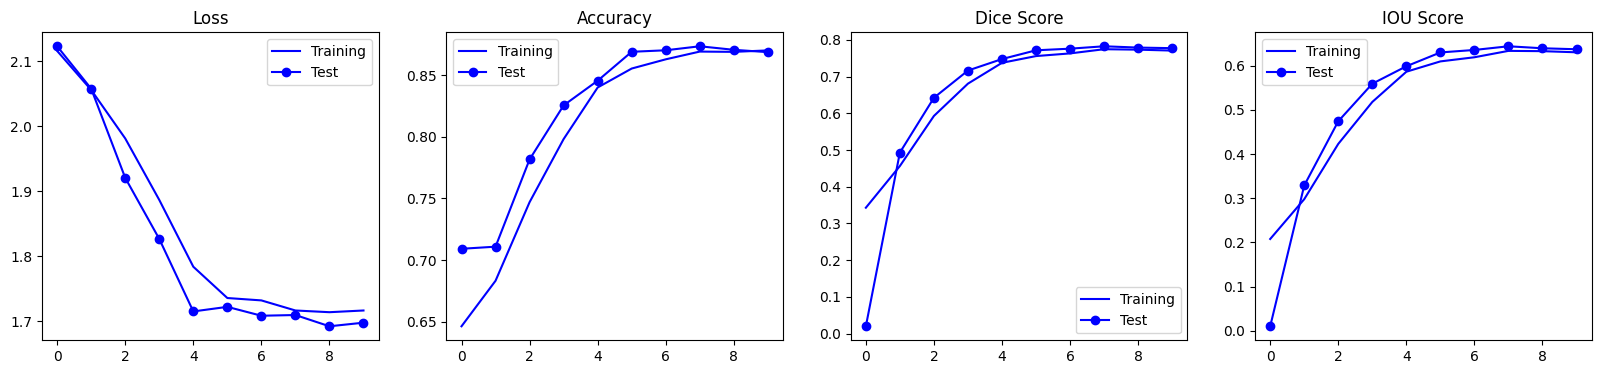

In [196]:
loss_tensor, val_loss_tensor, acc_tensor, val_acc_tensor, dice_tensor, val_dice_tensor, iou_tensor, val_iou_tensor = convert_to_tensor(loss, val_loss, acc, val_acc, dice, val_dice, iou, val_iou)
plot_metrics(loss_tensor, val_loss_tensor, acc_tensor, val_acc_tensor, dice_tensor, val_dice_tensor, iou_tensor, val_iou_tensor)


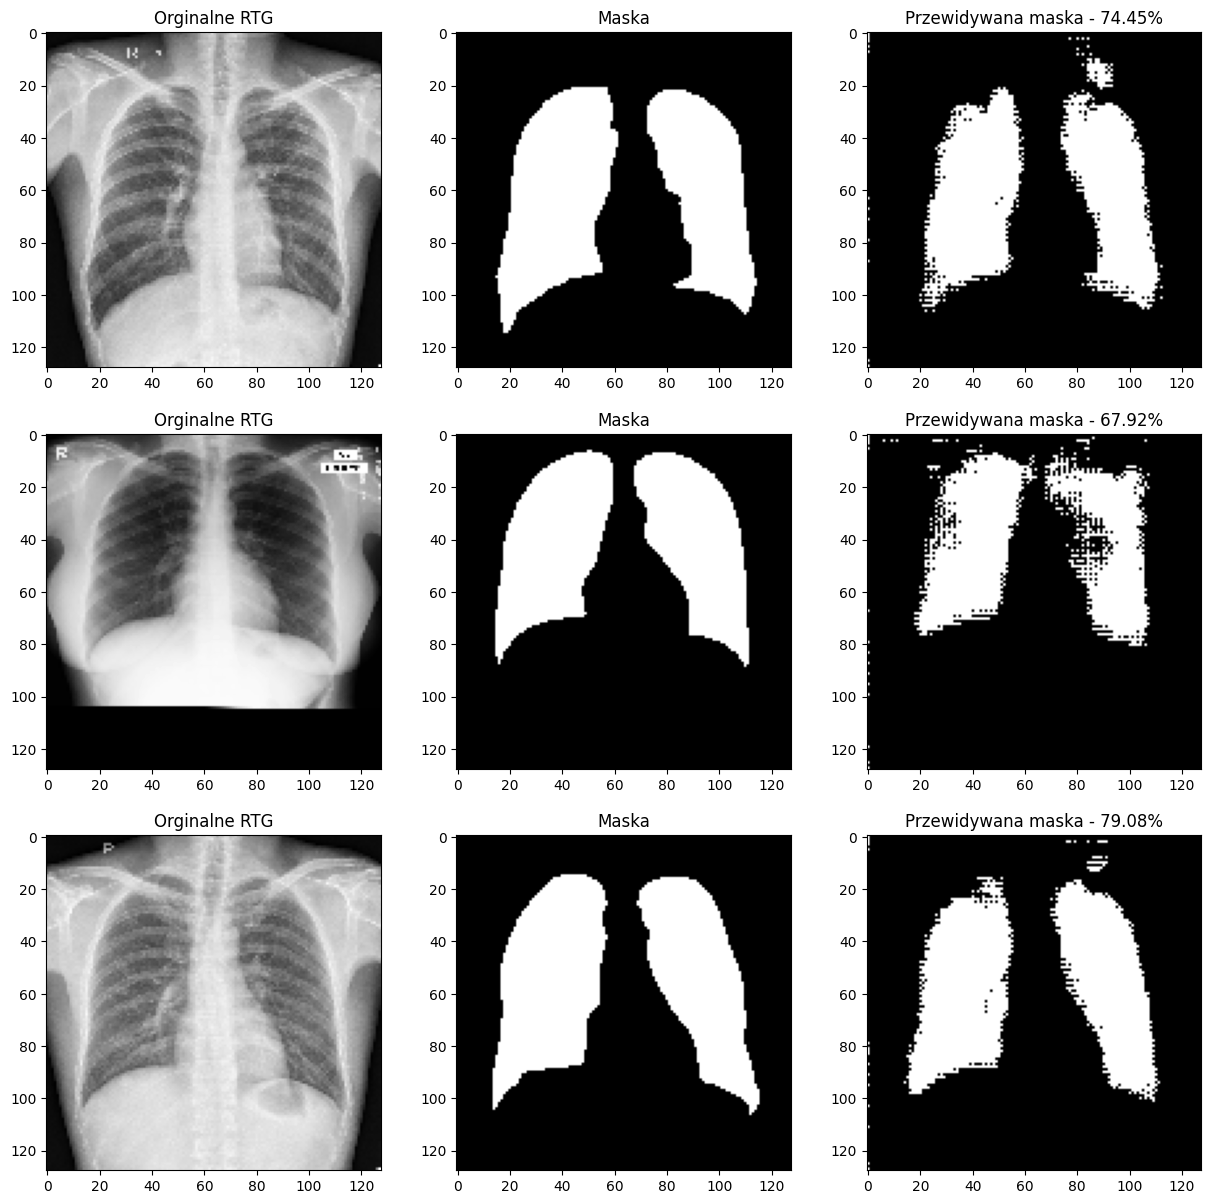

In [197]:
test_xray = DataLoader (train_ds, batch_size = 3, shuffle = True,  pin_memory = True)
show_results (model, test_xray)

In [198]:
load_checkpoint('LungResUnet.pth', model)

Wczytanie checkpoint: LungResUnet.pth


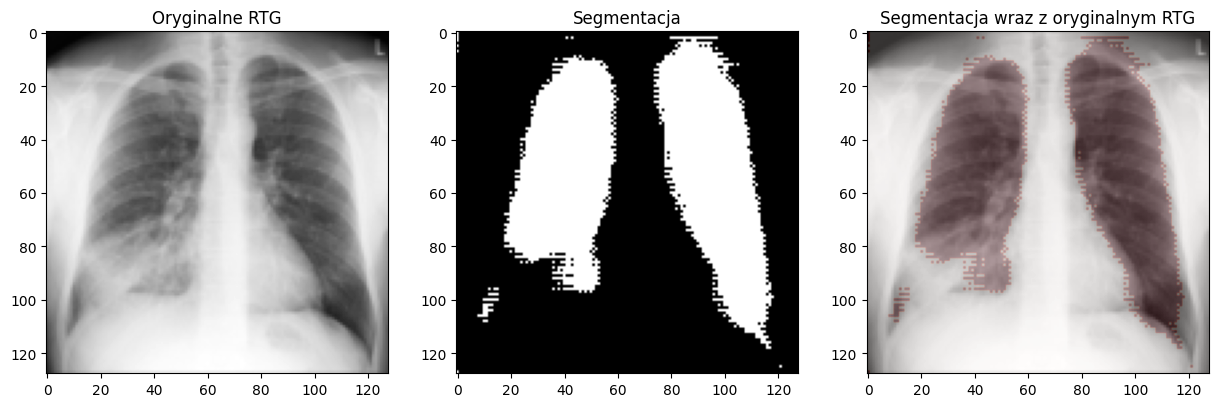

In [199]:
# Przykładowe użycie
image_path = '/content/zapalenie-test.jpeg'
predict_mask(model, image_path)

###Nadal ten sam model tylko zmiana ilości cech w modelu

In [200]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
# Hyper functions
model_2 =  ResUnet (in_channels = 1, out_channels = 1,features=[64, 128, 256]).to(device)
loss_fn = lungLoss ().to(device)
optimizer = optim.Adam (model_2.parameters (), lr = 1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau (optimizer, factor = 0.1, patience = 3)

In [201]:
history = fit (model_2, train_dl, valid_dl, loss_fn, optimizer, 10, calculate_metrics, device, checkpoint_path, scheduler)

=> saving checkpoint
Epoch [1/10], loss: 1.1091 - acc: 0.8390 - dice: 0.7536 - iou: 0.6307 | val_loss: 2.3849 - val_acc: 0.5904 - val_dice: 0.5488 - val_iou: 0.3798
=> saving checkpoint
Epoch [2/10], loss: 0.4023 - acc: 0.9606 - dice: 0.9205 - iou: 0.8535 | val_loss: 0.8716 - val_acc: 0.8995 - val_dice: 0.8255 - val_iou: 0.7060
=> saving checkpoint
Epoch [3/10], loss: 0.3228 - acc: 0.9683 - dice: 0.9355 - iou: 0.8793 | val_loss: 0.2940 - val_acc: 0.9724 - val_dice: 0.9455 - val_iou: 0.8968
Epoch [4/10], loss: 0.3127 - acc: 0.9685 - dice: 0.9363 - iou: 0.8807 | val_loss: 0.2955 - val_acc: 0.9701 - val_dice: 0.9412 - val_iou: 0.8893
=> saving checkpoint
Epoch [5/10], loss: 0.2545 - acc: 0.9747 - dice: 0.9497 - iou: 0.9044 | val_loss: 0.2290 - val_acc: 0.9775 - val_dice: 0.9548 - val_iou: 0.9138
=> saving checkpoint
Epoch [6/10], loss: 0.2308 - acc: 0.9776 - dice: 0.9542 - iou: 0.9126 | val_loss: 0.2127 - val_acc: 0.9789 - val_dice: 0.9583 - val_iou: 0.9201
=> saving checkpoint
Epoch [7/1

In [202]:
torch.save (model_2, 'FullLungResUnet64_128_256_3epoch.pth')

In [203]:
loss = history ['loss']
val_loss = history ['val_loss']
acc = history ['acc']
val_acc = history ['val_acc']
dice = history ['dice']
val_dice = history ['val_dice']
iou = history ['iou']
val_iou = history ['val_iou']

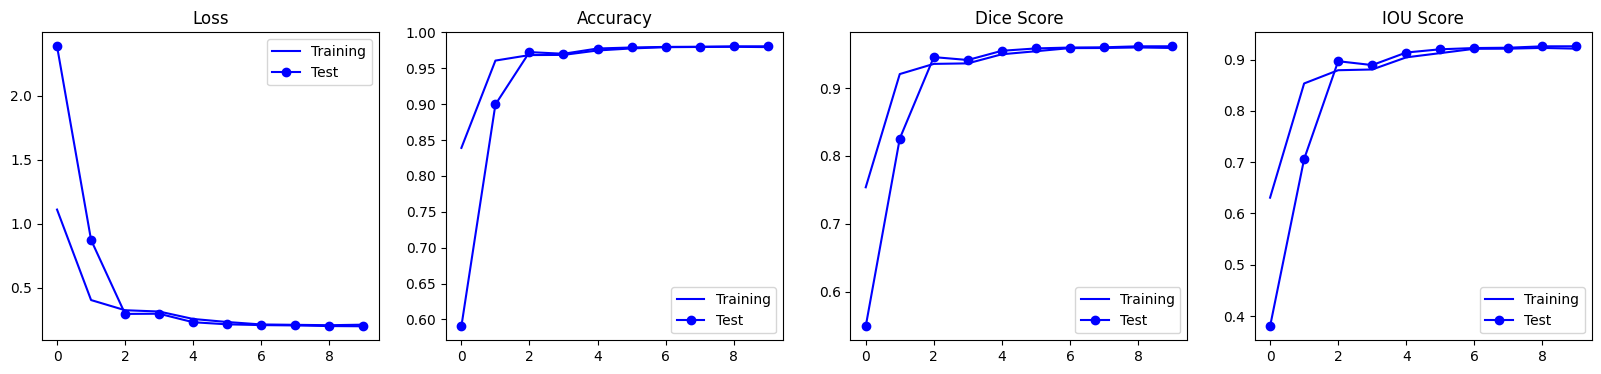

In [204]:
loss_tensor, val_loss_tensor, acc_tensor, val_acc_tensor, dice_tensor, val_dice_tensor, iou_tensor, val_iou_tensor = convert_to_tensor(loss, val_loss, acc, val_acc, dice, val_dice, iou, val_iou)
plot_metrics(loss_tensor, val_loss_tensor, acc_tensor, val_acc_tensor, dice_tensor, val_dice_tensor, iou_tensor, val_iou_tensor)

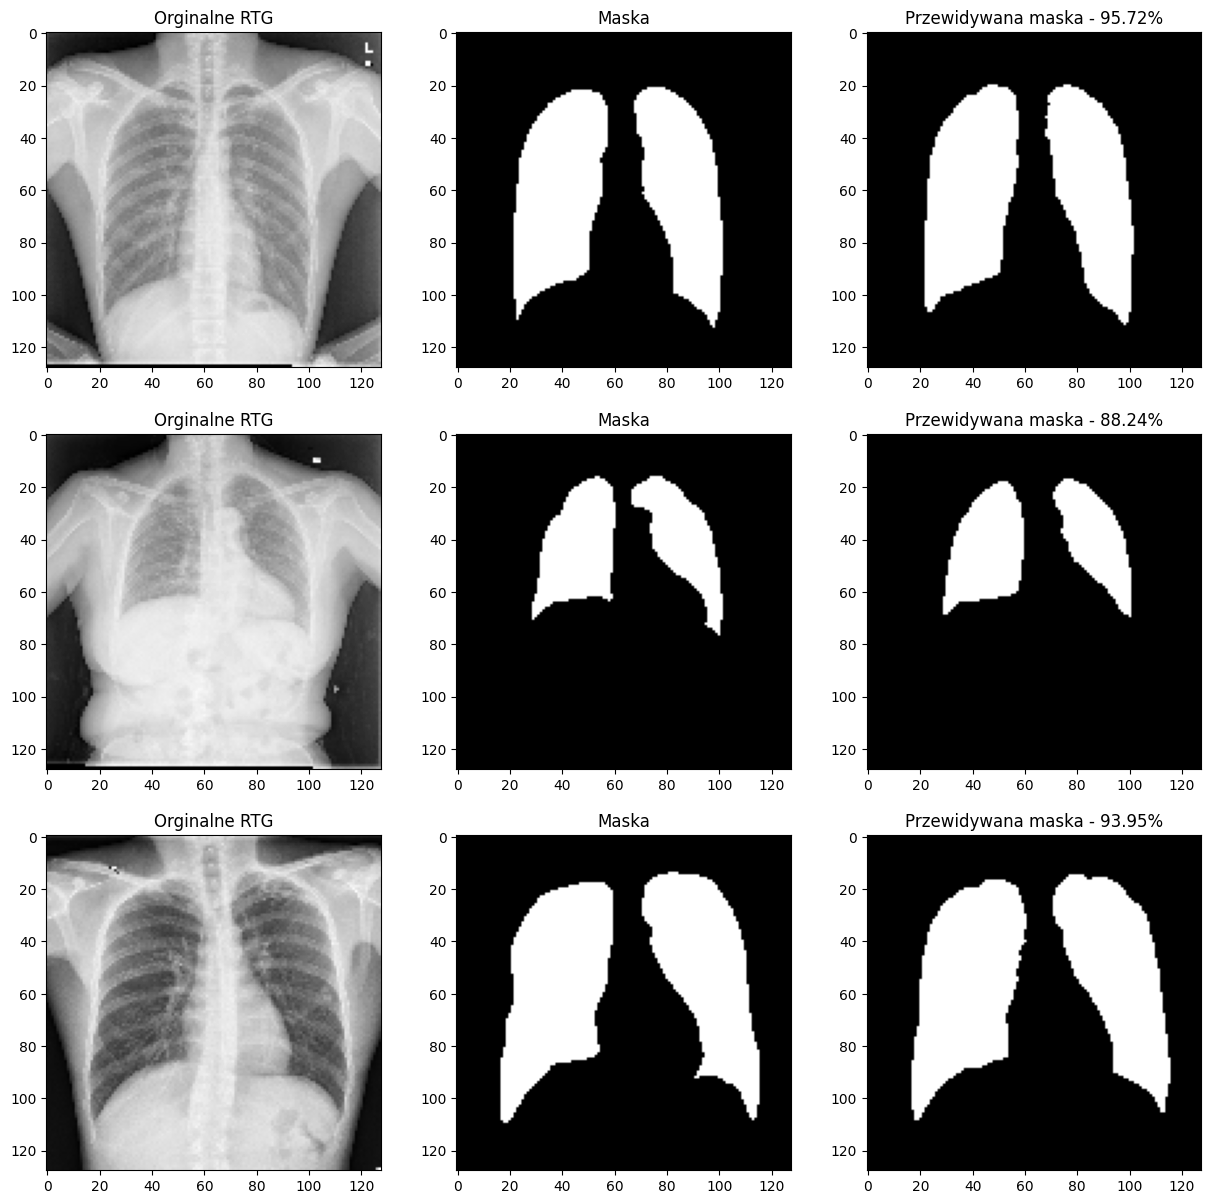

In [205]:
test_xray = DataLoader (train_ds, batch_size = 3, shuffle = True,  pin_memory = True)
show_results (model_2, test_xray)

In [206]:
load_checkpoint('LungResUnet.pth', model_2)

Wczytanie checkpoint: LungResUnet.pth


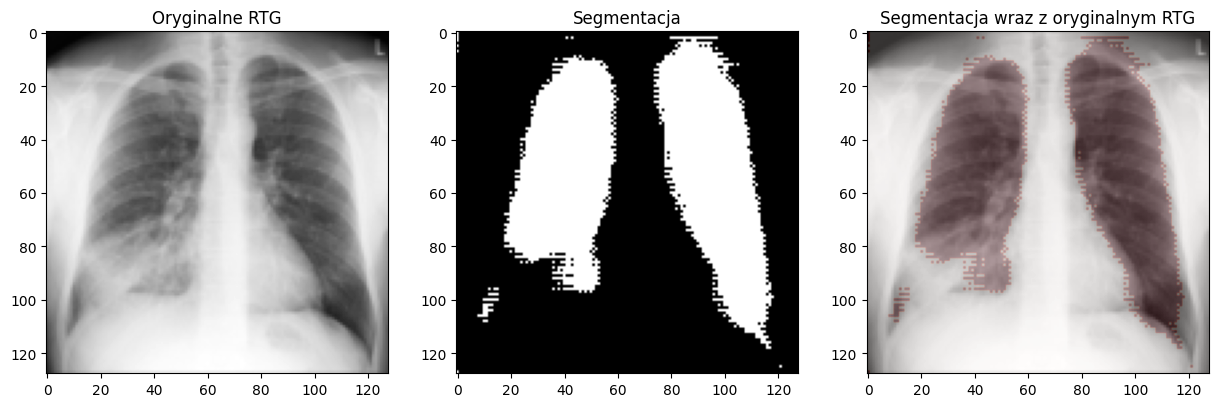

In [207]:
image_path = '/content/zapalenie-test.jpeg'
predict_mask(model, image_path)

In [208]:
print(model_2)

ResUnet(
  (input): InitBlock(
    (conv_block): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (conv_skip): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (downs): ModuleList(
    (0): ResBlock(
      (conv_block): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [209]:
summary(model_2, input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
            Conv2d-5         [-1, 64, 128, 128]             640
       BatchNorm2d-6         [-1, 64, 128, 128]             128
         InitBlock-7         [-1, 64, 128, 128]               0
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
           Conv2d-10          [-1, 128, 64, 64]          73,856
      BatchNorm2d-11          [-1, 128, 64, 64]             256
             ReLU-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]         147,584
           Conv2d-14          [-1, 128,

### Uproszczony ResUnet zmniejszona ilość warstw 46 a bylo 65

In [210]:
class InitBlock(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, stride=1):
        super(InitBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.conv_block(x) + self.conv_skip(x)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.conv_block(x) + self.conv_skip(x)

class ResUnet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[16, 32]):
        super(ResUnet, self).__init__()

        self.input = InitBlock(in_channels, features[0])

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        for feature in features:
            self.downs.append(ResBlock(feature, feature * 2, stride=2))
            feature *= 2

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(2 * feature, feature, kernel_size=2, stride=2))
            self.ups.append(ResBlock(2 * feature, feature))

        self.output = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        x = self.input(x)
        skip_connections.append(x)

        for i, down in enumerate(self.downs):
            x = down(x)
            if i < 1:
                skip_connections.append(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.output(x)

model = ResUnet(in_channels=3, out_channels=1, features=[16, 32])

In [214]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
# Hyper functions
model_2 =  ResUnet (in_channels = 1, out_channels = 1,features=[16, 32]).to(device)
loss_fn = lungLoss ().to(device)
optimizer = optim.Adam (model_2.parameters (), lr = 1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau (optimizer, factor = 0.1, patience = 3)

In [215]:
history = fit (model_2, train_dl, valid_dl, loss_fn, optimizer, 10, calculate_metrics, device, checkpoint_path, scheduler)

=> saving checkpoint
Epoch [1/10], loss: 1.8888 - acc: 0.6932 - dice: 0.5664 - iou: 0.3987 | val_loss: 2.0631 - val_acc: 0.5385 - val_dice: 0.5162 - val_iou: 0.3493
=> saving checkpoint
Epoch [2/10], loss: 1.5560 - acc: 0.7818 - dice: 0.6723 - iou: 0.5083 | val_loss: 1.7625 - val_acc: 0.6784 - val_dice: 0.6025 - val_iou: 0.4327
=> saving checkpoint
Epoch [3/10], loss: 1.2748 - acc: 0.8635 - dice: 0.7698 - iou: 0.6296 | val_loss: 1.2926 - val_acc: 0.8503 - val_dice: 0.7562 - val_iou: 0.6104
=> saving checkpoint
Epoch [4/10], loss: 1.1433 - acc: 0.8851 - dice: 0.7941 - iou: 0.6642 | val_loss: 1.0744 - val_acc: 0.8898 - val_dice: 0.7984 - val_iou: 0.6688
=> saving checkpoint
Epoch [5/10], loss: 0.9270 - acc: 0.9220 - dice: 0.8522 - iou: 0.7454 | val_loss: 0.8965 - val_acc: 0.9229 - val_dice: 0.8566 - val_iou: 0.7513
=> saving checkpoint
Epoch [6/10], loss: 0.8570 - acc: 0.9270 - dice: 0.8597 - iou: 0.7567 | val_loss: 0.8349 - val_acc: 0.9349 - val_dice: 0.8734 - val_iou: 0.7773
=> saving 

In [216]:
len(train_dl)

22

In [217]:
torch.save (model_2, 'SimpleResUnet16_32_5epoch.pth')

In [218]:
loss = history ['loss']
val_loss = history ['val_loss']
acc = history ['acc']
val_acc = history ['val_acc']
dice = history ['dice']
val_dice = history ['val_dice']
iou = history ['iou']
val_iou = history ['val_iou']

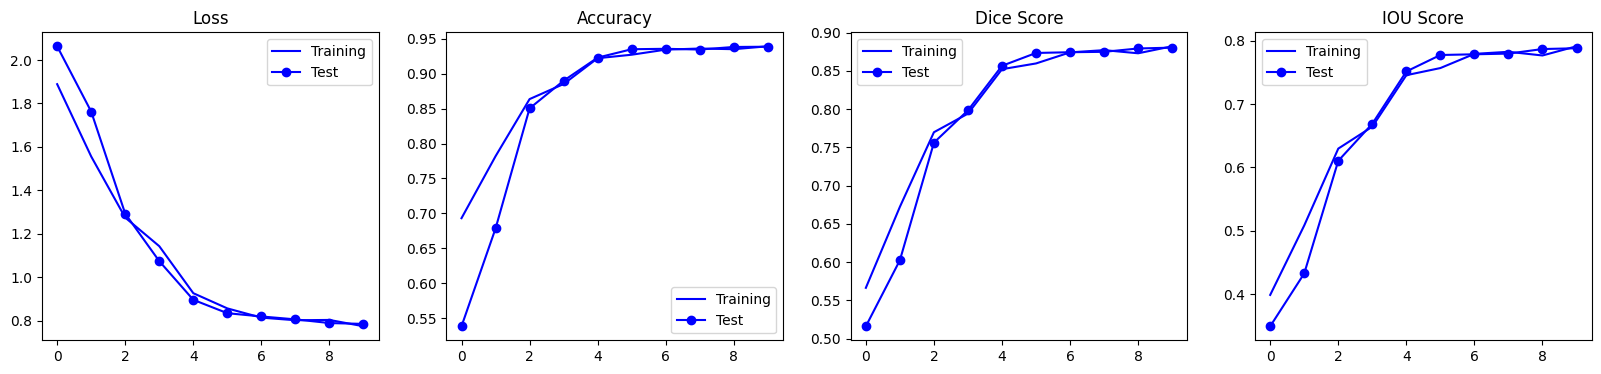

In [219]:
loss_tensor, val_loss_tensor, acc_tensor, val_acc_tensor, dice_tensor, val_dice_tensor, iou_tensor, val_iou_tensor = convert_to_tensor(loss, val_loss, acc, val_acc, dice, val_dice, iou, val_iou)

plot_metrics(loss_tensor, val_loss_tensor, acc_tensor, val_acc_tensor, dice_tensor, val_dice_tensor, iou_tensor, val_iou_tensor)

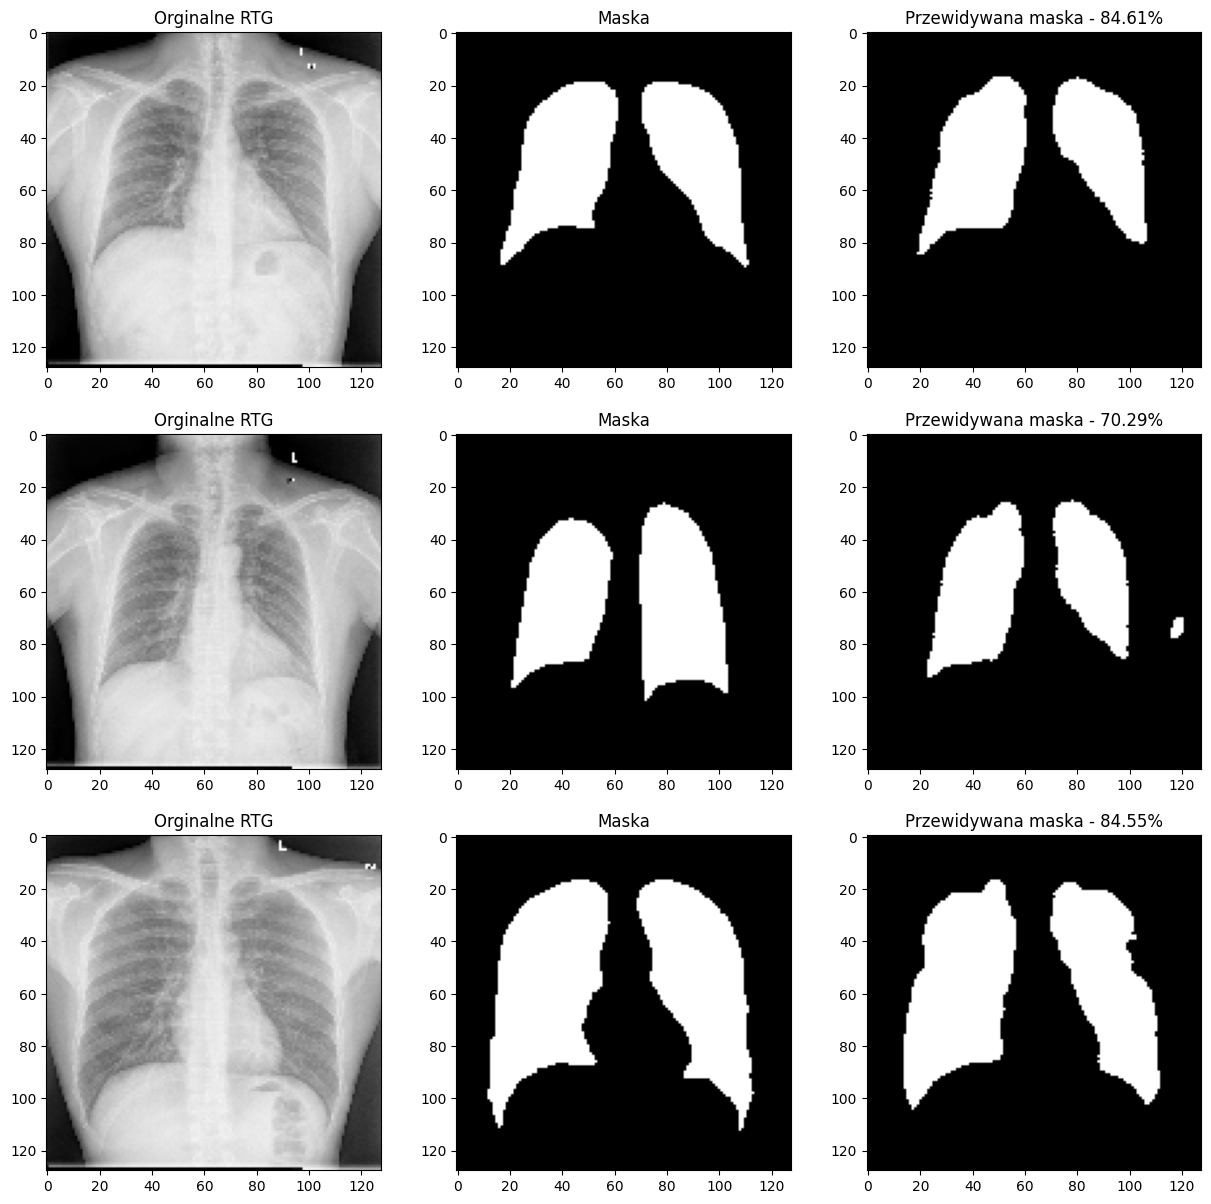

In [220]:
test_xray = DataLoader (train_ds, batch_size = 3, shuffle = True,  pin_memory = True)
show_results (model_2, test_xray)

In [221]:
summary(model_2, input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           2,320
            Conv2d-5         [-1, 16, 128, 128]             160
       BatchNorm2d-6         [-1, 16, 128, 128]              32
         InitBlock-7         [-1, 16, 128, 128]               0
       BatchNorm2d-8         [-1, 16, 128, 128]              32
              ReLU-9         [-1, 16, 128, 128]               0
           Conv2d-10           [-1, 32, 64, 64]           4,640
      BatchNorm2d-11           [-1, 32, 64, 64]              64
             ReLU-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 32, 64, 64]           9,248
           Conv2d-14           [-1, 32,

###Wielkość data set zwiekszona 10-krotnie

In [234]:
random.seed(42)
mask_names = os.listdir(mask_dir)[:1000]
trn_mask_names, val_mask_names = shuffle_split (mask_names)

train_ds = lungDataset (img_dir, mask_dir, trn_mask_names, trn_tfms)
valid_ds = lungDataset (img_dir, mask_dir, val_mask_names, val_tfms)

train_dl = DataLoader (train_ds, batch_size = 4, shuffle = True,  pin_memory = True)
valid_dl = DataLoader (train_ds, batch_size = 4, shuffle = False,  pin_memory = True)

In [235]:
class InitBlock(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, stride=1):
        super(InitBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.conv_block(x) + self.conv_skip(x)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.conv_block(x) + self.conv_skip(x)

class ResUnet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[16, 32]):
        super(ResUnet, self).__init__()

        self.input = InitBlock(in_channels, features[0])

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        for feature in features:
            self.downs.append(ResBlock(feature, feature * 2, stride=2))
            feature *= 2

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(2 * feature, feature, kernel_size=2, stride=2))
            self.ups.append(ResBlock(2 * feature, feature))

        self.output = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        x = self.input(x)
        skip_connections.append(x)

        for i, down in enumerate(self.downs):
            x = down(x)
            if i < 1:
                skip_connections.append(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.output(x)

model = ResUnet(in_channels=3, out_channels=1, features=[16, 32])

In [236]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
# Hyper functions
model_2 =  ResUnet (in_channels = 1, out_channels = 1,features=[16, 32]).to(device)
loss_fn = lungLoss ().to(device)
optimizer = optim.Adam (model_2.parameters (), lr = 1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau (optimizer, factor = 0.1, patience = 3)

In [ ]:
history = fit (model_2, train_dl, valid_dl, loss_fn, optimizer, 10, calculate_metrics, device, checkpoint_path, scheduler)

=> saving checkpoint
Epoch [1/10], loss: 1.1967 - acc: 0.8476 - dice: 0.7644 - iou: 0.6363 | val_loss: 0.6573 - val_acc: 0.9413 - val_dice: 0.8807 - val_iou: 0.7886
=> saving checkpoint
Epoch [2/10], loss: 0.5120 - acc: 0.9524 - dice: 0.9055 - iou: 0.8289 | val_loss: 0.4471 - val_acc: 0.9571 - val_dice: 0.9136 - val_iou: 0.8421
=> saving checkpoint
Epoch [3/10], loss: 0.3615 - acc: 0.9650 - dice: 0.9303 - iou: 0.8706 | val_loss: 0.3156 - val_acc: 0.9696 - val_dice: 0.9380 - val_iou: 0.8839
=> saving checkpoint
Epoch [4/10], loss: 0.3044 - acc: 0.9702 - dice: 0.9404 - iou: 0.8882 | val_loss: 0.2886 - val_acc: 0.9716 - val_dice: 0.9425 - val_iou: 0.8920


In [ ]:
len(train_dl,valid_dl)

In [ ]:
torch.save (model_2, 'SimpleResUnet16_32_5epoch_big_data.pth')

In [ ]:
loss = history ['loss']
val_loss = history ['val_loss']
acc = history ['acc']
val_acc = history ['val_acc']
dice = history ['dice']
val_dice = history ['val_dice']
iou = history ['iou']
val_iou = history ['val_iou']

In [ ]:
loss_tensor, val_loss_tensor, acc_tensor, val_acc_tensor, dice_tensor, val_dice_tensor, iou_tensor, val_iou_tensor = convert_to_tensor(loss, val_loss, acc, val_acc, dice, val_dice, iou, val_iou)

plot_metrics(loss_tensor, val_loss_tensor, acc_tensor, val_acc_tensor, dice_tensor, val_dice_tensor, iou_tensor, val_iou_tensor)

In [ ]:
test_xray = DataLoader (train_ds, batch_size = 3, shuffle = True,  pin_memory = True)
show_results (model_2, test_xray)